#  필요한 라이브러리 불러오기

In [101]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow_addons as tfa

# 데이터 증강
데이터 증강을 위한 함수를 만들어보자 <br>
사용된 데이터 증강 : 좌우반전, 상하반전, 회전, 대비조절, 밝기조절, 색도조절, 채도조절

In [102]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) #이미지를 랜덤하게 좌우로 반전
    
    image = tf.image.random_flip_up_down(image) #이미지를 랜덤하게 상하로 반전
    
    angle = tf.random.uniform([], -0.2, 0.2) #랜덤한 각도를 생성
    image = tfa.image.rotate(image, angle) #이미지를 생성한 랜덤한 각도로 회전
    
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5) #이미지의 대비를 랜덤하게 조절
    
    image = tf.image.random_brightness(image, max_delta=0.1) #이미지의 밝기를 랜덤하게 조절
    
    image = tf.image.random_hue(image, max_delta=0.05) #이미지의 색조를 랜덤하게 조절

    image = tf.image.random_saturation(image, lower=0.5, upper=1.5) #)이미지의 채도를 랜덤하게 조절
    
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2) 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat() 
    ds = ds.batch(32) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

# 데이터 증강이 잘 되었는지 확인

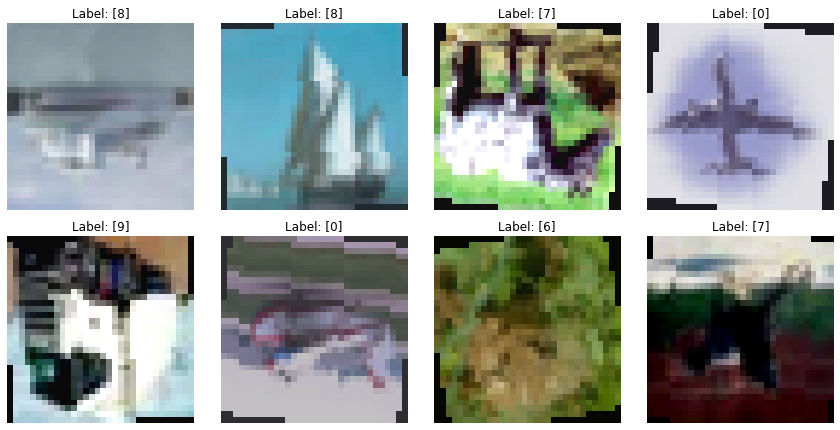

In [103]:
sample_batch = next(iter(train_ds))
augmented_images, augmented_labels = sample_batch
num_images_to_show = 8
plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    ax = plt.subplot(4, 4, i+1)
    
    # vmin과 vmax를 지정하여 색상 맵 설정
    plt.imshow(augmented_images[i], vmin=0., vmax=1.)
    
    plt.title(f"Label: {augmented_labels[i].numpy()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Resnet 모델 구축

In [104]:
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [105]:
model = ResNet18()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 32, 32, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 32, 32, 64)   256         conv2d_140[0][0]                 
__________________________________________________________________________________________________
activation_119 (Activation)     (None, 32, 32, 64)   0           batch_normalization_140[0][0]    
____________________________________________________________________________________________

In [106]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 학습루프

In [109]:
# 학습 루프
num_epochs = 100

# steps_per_epoch를 설정합니다. 
steps_per_epoch = len(x_train) // 32

# 학습을 수행합니다.
history = model.fit(train_ds, 
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/100
1562/1562 [==============================] - 62s 39ms/step - loss: 0.8202 - accuracy: 0.7085
Epoch 2/100
1562/1562 [==============================] - 61s 39ms/step - loss: 0.7413 - accuracy: 0.7386
Epoch 3/100
1562/1562 [==============================] - 85s 54ms/step - loss: 0.6797 - accuracy: 0.7616
Epoch 4/100
1562/1562 [==============================] - 114s 73ms/step - loss: 0.6289 - accuracy: 0.7789
Epoch 5/100
1562/1562 [==============================] - 61s 39ms/step - loss: 0.5777 - accuracy: 0.7976
Epoch 6/100
1562/1562 [==============================] - 61s 39ms/step - loss: 0.5399 - accuracy: 0.8102
Epoch 7/100
1562/1562 [==============================] - 61s 39ms/step - loss: 0.5082 - accuracy: 0.8225
Epoch 8/100
1562/1562 [==============================] - 61s 39ms/step - loss: 0.4759 - accuracy: 0.8341
Epoch 9/100
1562/1562 [==============================] - 61s 39ms/step - loss: 0.4473 - accuracy: 0.8432
Epoch 10/100
1562/1562 [==============================

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_7: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)


# 정확도 확인

In [111]:
test_loss, test_acc = model.evaluate(test_ds.batch(32))
print(f"Test accuracy: {test_acc * 100:.2f}%")


313/313 [==============================] - 4s 12ms/step - loss: 0.4867 - accuracy: 0.8960
Test accuracy: 89.60%


# 데이터 시각화

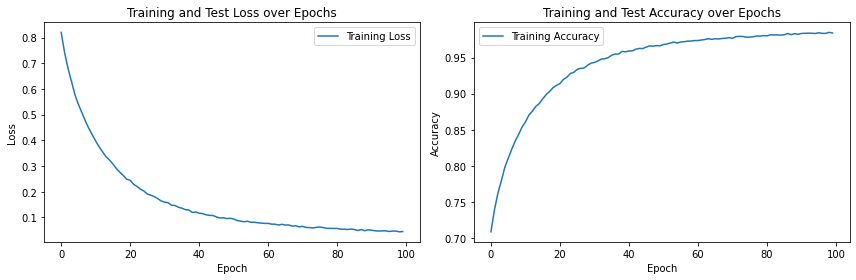

In [112]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# 훈련 손실 및 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
if hasattr(model, 'test_loss'):  # TestLossCallback가 test_loss를 저장한 경우에만 시각화
    plt.plot([i * test_loss_callback.evaluation_interval for i in range(len(history.history["loss"]))],
             [model.test_loss] * len(history.history["loss"]),
             label="Test Loss", linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()

# 훈련 정확도 및 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
if hasattr(model, 'test_loss'):  # TestLossCallback가 test_loss를 저장한 경우에만 시각화
    plt.plot([i * test_loss_callback.evaluation_interval for i in range(len(history.history["accuracy"]))],
             [test_acc] * len(history.history["accuracy"]),
             label="Test Accuracy", linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# 컨퓨전 매트릭스

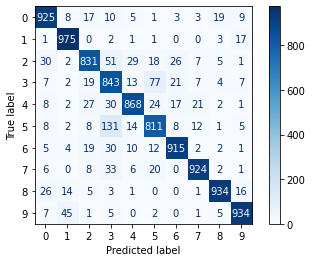

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes using the trained model
predicted_probs = model.predict(x_test)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display the confusion matrix
classes = [str(i) for i in range(10)]  # Assuming you have 10 classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.show()

# 학습 확인

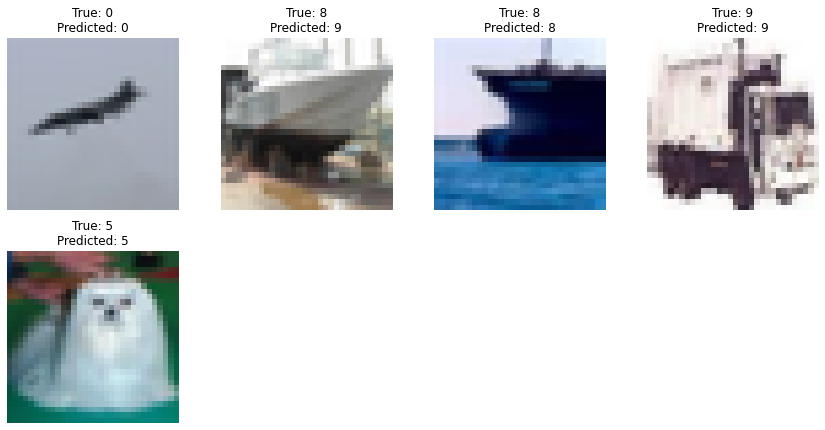

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Get some data to visualize
num_images_to_visualize = 5  # 변경된 부분: 8 -> 5
sample_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Predict classes using the trained model
predicted_probs = model.predict(sample_images)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Visualize the predicted results
plt.figure(figsize=(12, 12))
for i in range(num_images_to_visualize):
    plt.subplot(4, 4, i+1)  # 변경된 부분: 4, 4 -> 5, 1
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_labels[i][0]}\nPredicted: {predicted_classes[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()